In [1]:
%reset -f
testID = 0

In [2]:
import os
import shutil

import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model

# SkLearn
import sklearn.preprocessing as SklPreProcessing
import sklearn.metrics as SklMetrics

%matplotlib inline

Using TensorFlow backend.


In [41]:
class Test:
    resultsRootDir = 'results'
    testID = None
    eegDataRaw = None
    eegHeader = None
    dataFileName = None
    model = None
    trainTestMap = None
    cmdHistory = ''
    cmdCount = 0
    
    def __init__(self, testID, filename):
        self.testID = str(testID).zfill(5)
        self.__createTestResultsDir()
        self.dataFileName = filename
        self.ResetState()
        
    def ResetState(self, filename=None):
        tmpFileName = ''
        cmdHistory = ''
        cmdCount = 0
        
        if filename is None:
            tmpFileName = self.dataFileName
        else:
            tmpFileName = filename
            
        self.__loadData(tmpFileName)
    
    def GetFeatureNames(self):
        return self.eegHeader[:-1]
    
    def GetCmdHistory(self):
        return self.cmdHistory
    
    def RemoveFeature(self, index):
        featureCount = len(self.eegHeader) - 1
        if index >= 0 and index < featureCount:
            self.__addToHistory('RemoveFeature_Idx:' + str(index) + '_' + self.eegHeader[index])
            self.eegHeader = np.delete(self.eegHeader, index)
            self.eegDataRaw = np.delete(self.eegDataRaw, index, axis=1)
                
    def PlotFeatures(self, filePrefix=None, figWidth=20, figHeight=20):
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)
        
        featureCount = len(self.eegHeader) - 1
        idxSubplot = 0
        
        for itr in range(featureCount):
            idxSubplot = idxSubplot + 1
            currAx = fig.add_subplot(featureCount + 1, 1, idxSubplot)
            currAx.grid()
            currAx.plot(self.eegDataRaw[:, itr])
            currAx.set_title(self.eegHeader[itr])
        
        idxSubplot = idxSubplot + 1
        currAx = fig.add_subplot(featureCount + 1, 1, idxSubplot)
        currAx.grid()
        currAx.plot(self.eegDataRaw[:, -1])
        currAx.set_title(self.eegHeader[-1])

        if filePrefix is None:
            plt.show()
        else:
            pathToFile = self.resultsRootDir + "/" + self.testID + "/" + filePrefix
            plt.savefig(pathToFile)
            
    def PlotBoxPlots(self, filePrefix=None, figWidth=20, figHeight=20):
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)
        
        ax1 = fig.add_subplot(2, 1, 1)
        ax1.set_title('Feature range: Full')
        ax1.boxplot(self.eegDataRaw[:, :-1]
                    , sym='b.'
                    , vert=False
                    , whis='range'
                    , labels=self.eegHeader[:-1]
                    , meanline=True
                    , showbox=True
                    , showfliers=True)
        
        ax2 = fig.add_subplot(2, 1, 2)
        ax2.set_title('Feature range: [5%, 95%]')
        ax2.boxplot(self.eegDataRaw[:, :-1]
                    , sym='b.'
                    , vert=False
                    , whis=[5, 95]
                    , labels=self.eegHeader[:-1]
                    , meanline=True
                    , showbox=True
                    , showfliers=False)
        
        if filePrefix is not None:
            pathToFile = self.resultsRootDir + "/" + self.testID + "/" + filePrefix
            plt.savefig(pathToFile)
            
    def PlotMeanDistribution(self, filePrefix=None, figWidth=20, figHeight=20):
        idxEyeClosed = np.where(self.eegDataRaw[:, -1] == 1)[0]
        idxEyeOpened = np.where(self.eegDataRaw[:, -1] == 0)[0]
        
        featureCount = len(self.eegHeader) - 1
        xTick = np.array(range(featureCount))
        
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)

        ax = fig.add_subplot(1, 1, 1)
        ax.grid()
        ax.set_title('Mean Distribution')
        ax.set_xticklabels(self.eegHeader[0:-1])
        ax.set_xticks(xTick)

        ax.plot(xTick, self.eegDataRaw[idxEyeOpened][:, 0:featureCount].mean(axis=0), 'bo')
        ax.plot(xTick, self.eegDataRaw[idxEyeClosed][:, 0:featureCount].mean(axis=0), 'ro')
        ax.plot(xTick, self.eegDataRaw[:, 0:featureCount].mean(axis=0), 'go')

        ax.legend(['Eye Open', 'Eye Closed', 'Both'])
        
        if filePrefix is not None:
            pathToFile = self.resultsRootDir + "/" + self.testID + "/" + filePrefix
            plt.savefig(pathToFile)

    def PlotStdDevDistribution(self, filePrefix=None, figWidth=20, figHeight=20):
        idxEyeClosed = np.where(self.eegDataRaw[:, -1] == 1)[0]
        idxEyeOpened = np.where(self.eegDataRaw[:, -1] == 0)[0]
        
        featureCount = len(self.eegHeader) - 1
        xTick = np.array(range(featureCount))
        
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)

        ax = fig.add_subplot(1, 1, 1)
        ax.grid()
        ax.set_title('Standard Deviation Distribution')
        ax.set_xticklabels(self.eegHeader[0:-1])
        ax.set_xticks(xTick)

        ax.plot(xTick, self.eegDataRaw[idxEyeOpened][:, 0:featureCount].std(axis=0), 'bo')
        ax.plot(xTick, self.eegDataRaw[idxEyeClosed][:, 0:featureCount].std(axis=0), 'ro')
        ax.plot(xTick, self.eegDataRaw[:, 0:featureCount].std(axis=0), 'go')

        ax.legend(['Eye Open', 'Eye Closed', 'Both'])
        
        if filePrefix is not None:
            pathToFile = self.resultsRootDir + "/" + self.testID + "/" + filePrefix
            plt.savefig(pathToFile)

    def NormalizeData(self):
        self.__addToHistory('NormalizeData')
        scaler = SklPreProcessing.MinMaxScaler(feature_range=(0, 1))
        self.eegDataRaw = scaler.fit_transform(self.eegDataRaw)
        
    def RemoveOutliers(self, upperLimit=None, lowerLimit=None):
        outLierIndexes = set()
        result = {}
        result['upper'] = set()
        result['lower'] = set()
        
        self.__addToHistory('RemoveOutliers_Upper:' + str(upperLimit)
                            + '_Lower:' + str(lowerLimit))
        featureCount = len(self.eegHeader) - 1

        if upperLimit is not None:
            for itr in range(featureCount):
                outLiers = np.where(self.eegDataRaw[:, itr] > upperLimit)[0]
                if len(outLiers) > 0:
                    for i in xrange(len(outLiers)):
                        result['upper'].add(outLiers[i])

        if lowerLimit is not None:
            for itr in range(featureCount):
                outLiers = np.where(self.eegDataRaw[:, itr] < lowerLimit)[0]
                if len(outLiers) > 0:
                    for i in xrange(len(outLiers)):
                        result['lower'].add(outLiers[i])
                        
        deleteIndexes = list(result['upper'].union(result['lower']))
        self.eegDataRaw = np.delete(self.eegDataRaw, deleteIndexes, axis=0)
        
        return result
    
    def FeatureCorrelationMatrix(self, filePrefix=None, figWidth=20, figHeight=20):
        # Compute the correlation matrix
        corr = pd.DataFrame(data=self.eegDataRaw[:, :-1], columns=list(self.eegHeader[:-1])).corr()
        
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        
        # Set up the matplotlib figure
        fig = plt.figure()
        fig.set_figwidth(figWidth)
        fig.set_figheight(figHeight)
        
        ax = fig.add_subplot(1, 1, 1)
        ax.set_title("Feature correlation matrix")
        
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(240, 10, as_cmap=True)
        
        # Draw the heatmap
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})
        
        if filePrefix is not None:
            pathToFile = self.resultsRootDir + "/" + self.testID + "/" + filePrefix
            plt.savefig(pathToFile)
            
    def CompileModel(self, lagCount, testSetPortion, neuronCount, modelArchitectureFilename,
                     lossFunc='mae', optimizerFunc='adam'):
        self.__addToHistory('CompileModel_Lag:' + str(lagCount)
                            + '_TestSize:' + str(testSetPortion)
                            + '_NeuronCount:' + str(neuronCount)
                            + '_LossFunc:' + str(lossFunc)
                            + '_OptimizerFunc:' + str(optimizerFunc))
        
        supervisedDataset = self.__timeSeriesToSupervised(lagCount)
        print supervisedDataset.shape
        featureCount = len(self.eegHeader) - 1
        
        splitPoint = int(testSetPortion * supervisedDataset.shape[0])
        values = supervisedDataset.values
        trainingSet = values[:splitPoint, :]
        testingSet = values[splitPoint:, :]
        
        self.trainTestMap = {}

        self.trainTestMap['trainingSet_inFeatures'] = trainingSet[:, :-1]
        self.trainTestMap['trainingSet_outFeature'] = trainingSet[:, -1]
        
        self.trainTestMap['testingSet_inFeatures'] = testingSet[:, :-1]
        self.trainTestMap['testingSet_outFeature'] = testingSet[:, -1]
        
        # reshape input to be 3D [samples, timesteps, features]
        featureDimSize = (((featureCount + 1) * lagCount) + featureCount) / lagCount
        print featureDimSize
#         featureDimSize = 22
        
        print featureDimSize
        print self.trainTestMap['trainingSet_inFeatures'].shape
        print self.trainTestMap['trainingSet_outFeature'].shape
        
        print self.trainTestMap['testingSet_inFeatures'].shape
        print self.trainTestMap['testingSet_outFeature'].shape
        
        self.trainTestMap['trainingSet_inFeatures_reShaped'] = self.trainTestMap['trainingSet_inFeatures'].reshape(
            (self.trainTestMap['trainingSet_inFeatures'].shape[0], lagCount, featureDimSize))
        
        self.trainTestMap['testingSet_inFeatures_reShaped'] = self.trainTestMap['testingSet_inFeatures'].reshape(
            (self.trainTestMap['testingSet_inFeatures'].shape[0], lagCount, featureDimSize))
        
        print "Split:                 ", testSetPortion * 100, "-", (100 - (testSetPortion * 100))
        print "train.shape:           ", trainingSet.shape
        print "test.shape:            ", testingSet.shape
        print "self.eegDataRaw.shape: ", self.eegDataRaw.shape
        
        # design network
        self.model = Sequential()
        print (self.trainTestMap['trainingSet_inFeatures_reShaped'].shape[1],
               self.trainTestMap['trainingSet_inFeatures_reShaped'].shape[2])
        
        self.model.add(
            LSTM(neuronCount,
                 input_shape=(
                     self.trainTestMap['trainingSet_inFeatures_reShaped'].shape[1],
                     self.trainTestMap['trainingSet_inFeatures_reShaped'].shape[2])
                )
        )
        
        self.model.add(Dense(1))
        self.model.compile(loss=lossFunc, optimizer=optimizerFunc)
        
        # Visualize LSTM network
        pathToFile = self.resultsRootDir + "/" + self.testID + "/" + modelArchitectureFilename
        plot_model(self.model, to_file=pathToFile, show_shapes=True)
        
    def FitModel(self, epochCount, batchSize):
        assert self.model != None, 'Model not compiled'
        
        self.__addToHistory('FitModel_EpochCount:' + str(epochCount)
                            + '_BatchSize:' + str(batchSize))
        
#         print self.trainTestMap

        print self.trainTestMap['trainingSet_inFeatures_reShaped'].shape
        print self.trainTestMap['trainingSet_outFeature'].shape
        
        print self.trainTestMap['testingSet_inFeatures'].shape
        print self.trainTestMap['testingSet_outFeature'].shape
        
        
        # Fit model
        history = self.model.fit(self.trainTestMap['trainingSet_inFeatures_reShaped'],
                                 self.trainTestMap['trainingSet_outFeature'],
                                 epochs=epochCount,
                                 batch_size=batchSize,
                                 validation_data=(
                                     self.trainTestMap['testingSet_inFeatures'],
                                     self.trainTestMap['testingSet_outFeature']
                                 ),
                                 verbose=2, shuffle=False)
        
        self.model = None
        self.trainTestMap = None
    
    def __createTestResultsDir(self):
        dirName = "%s/%s" % (self.resultsRootDir, self.testID)
        if os.path.exists(dirName):
            shutil.rmtree(dirName)
        os.makedirs(dirName)
        
    def __loadData(self, filename):
        self.eegDataRaw = np.genfromtxt(filename, delimiter=',', skip_header=1)
        self.eegHeader = np.genfromtxt(filename, delimiter=',', max_rows=1, dtype=str)

    def __timeSeriesToSupervised(self, lagCount):
        featureCount = len(self.eegHeader) - 1

        dfInput = pd.DataFrame(self.eegDataRaw[:, :-1])
        dfOutput = pd.DataFrame(self.eegDataRaw[:, -1])
        
        cols, names = list(), list()

        for i in range(lagCount, 0, -1):
            cols.append(dfInput.shift(i))
            cols.append(dfOutput.shift(i))
            names += [('%s(t-%d)' % (self.eegHeader[j], i)) for j in range(featureCount)]
            names += [('%s(t-%d)' % (self.eegHeader[-1], i))]

        cols.append(dfInput)
        cols.append(dfOutput)
        names += [('%s(t)' % self.eegHeader[j]) for j in range(featureCount)]
        names += [('%s(t)' % self.eegHeader[-1])]

        agg = pd.concat(cols, axis=1)
        agg.columns = names

        # Drop rows containing NaN values
        agg.dropna(inplace=True)
        return agg
    
    def __addToHistory(self, newCmd):
        tmpStr = ''
        if self.cmdCount > 0:
            tmpStr += '\n'
            for itr in range(self.cmdCount):
                tmpStr += '+'
                
        tmpStr += newCmd
        self.cmdHistory += tmpStr
        self.cmdCount += 1

In [42]:
testID += 1

print "TestID: ", testID
a = Test(testID, 'EEGEyeState.arff.csv')

print a.GetCmdHistory()
a.RemoveFeature(2)
a.CompileModel(1, 0.2, 50, 'aaaa')
print a.GetCmdHistory()

TestID:  21

(14979, 28)
27
27
(2995, 27)
(2995,)
(11984, 27)
(11984,)
Split:                  20.0 - 80.0
train.shape:            (2995, 28)
test.shape:             (11984, 28)
self.eegDataRaw.shape:  (14980, 14)
(1, 27)
RemoveFeature_Idx:2_F3
+CompileModel_Lag:1_TestSize:0.2_NeuronCount:50_LossFunc:mae_OptimizerFunc:adam


TestID:  18
RemoveOutliers_Upper_5000_Lower_None
+NormalizeData


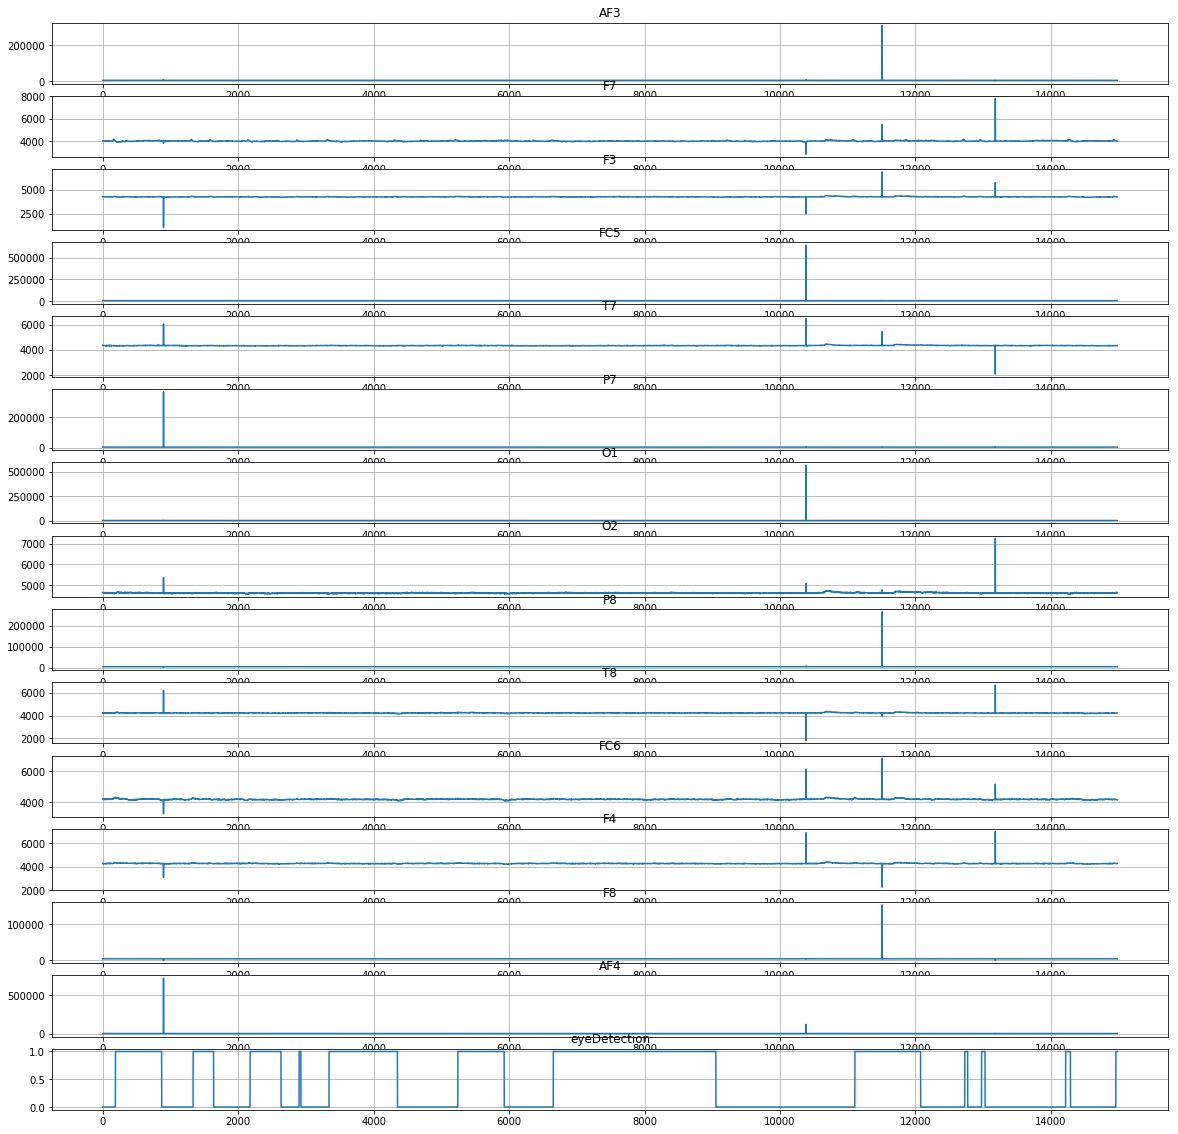

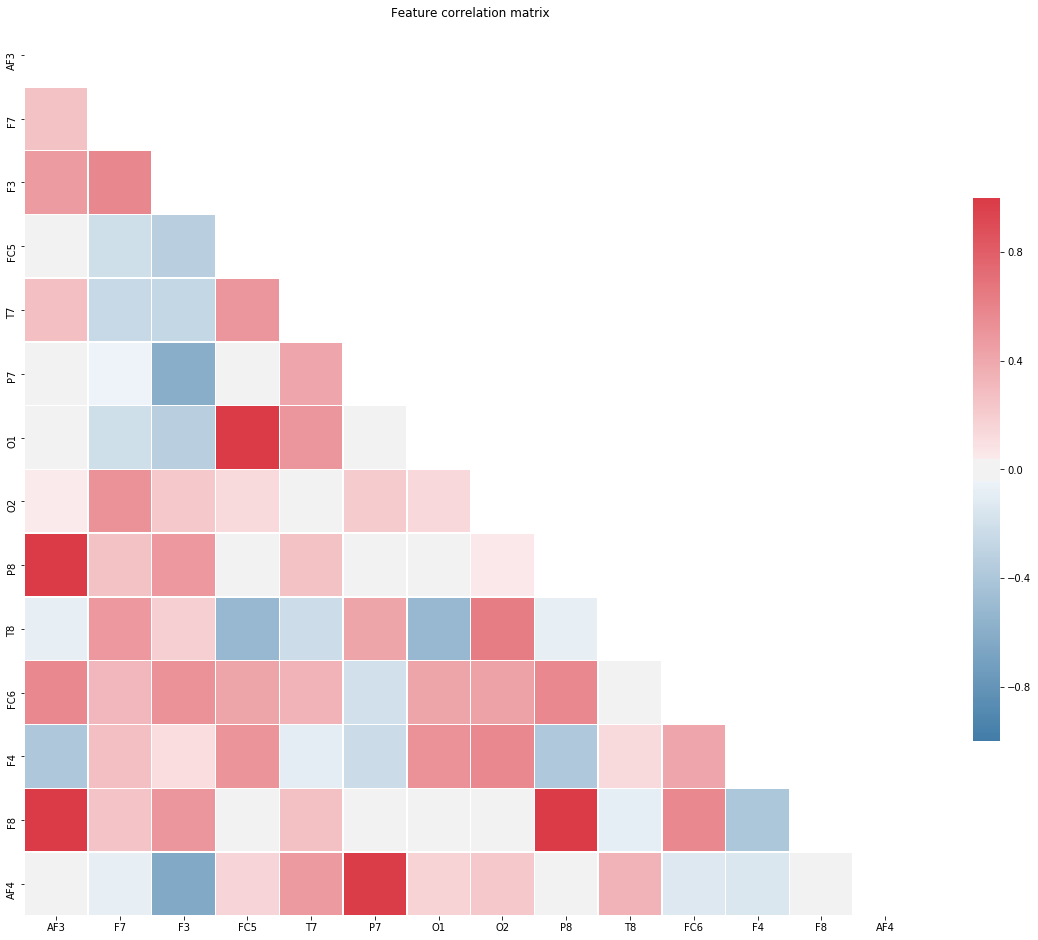

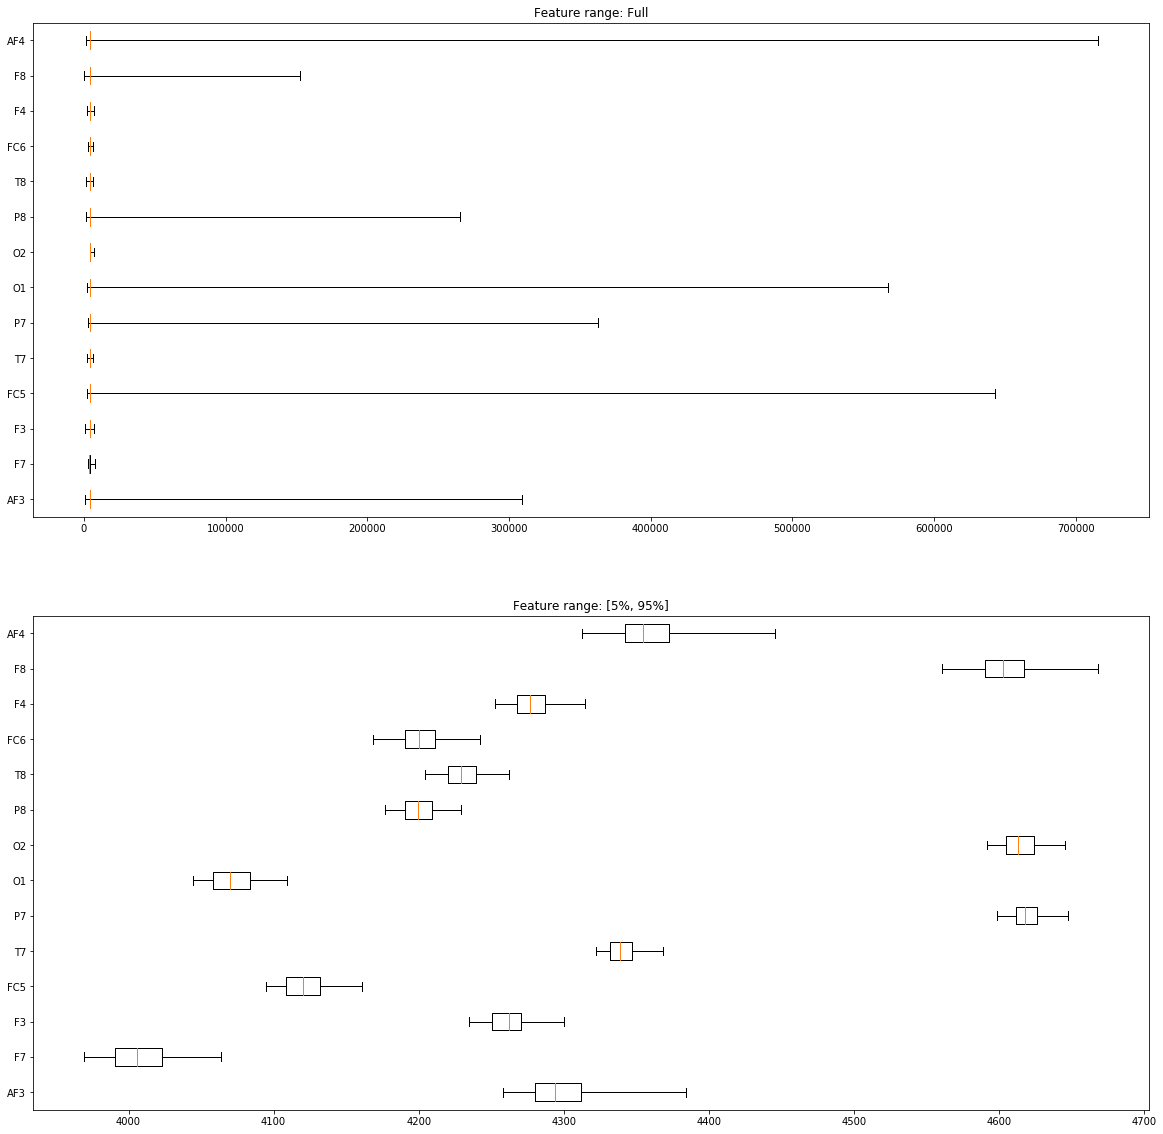

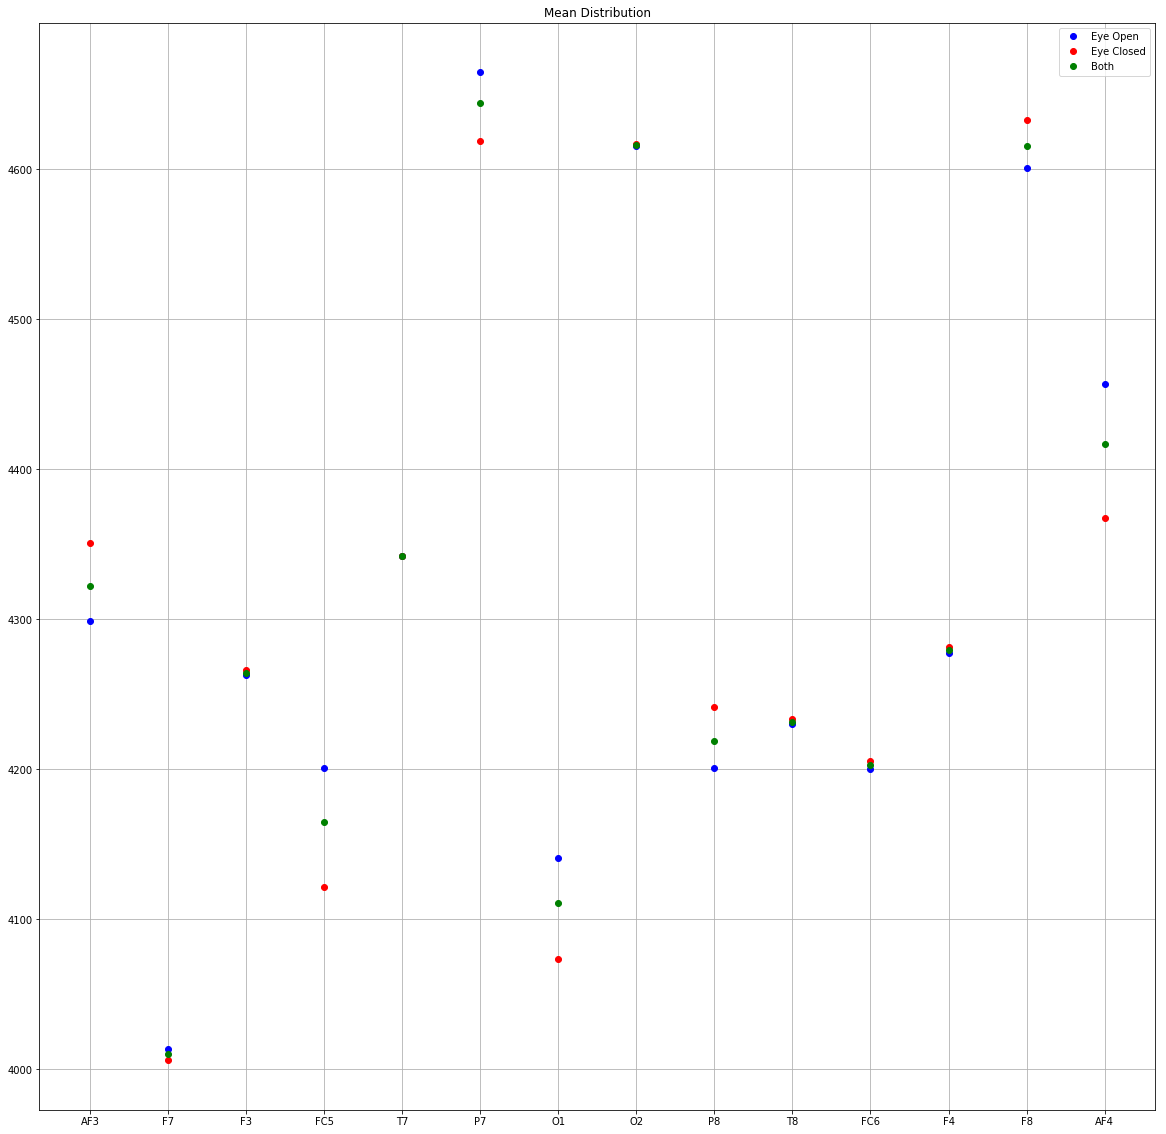

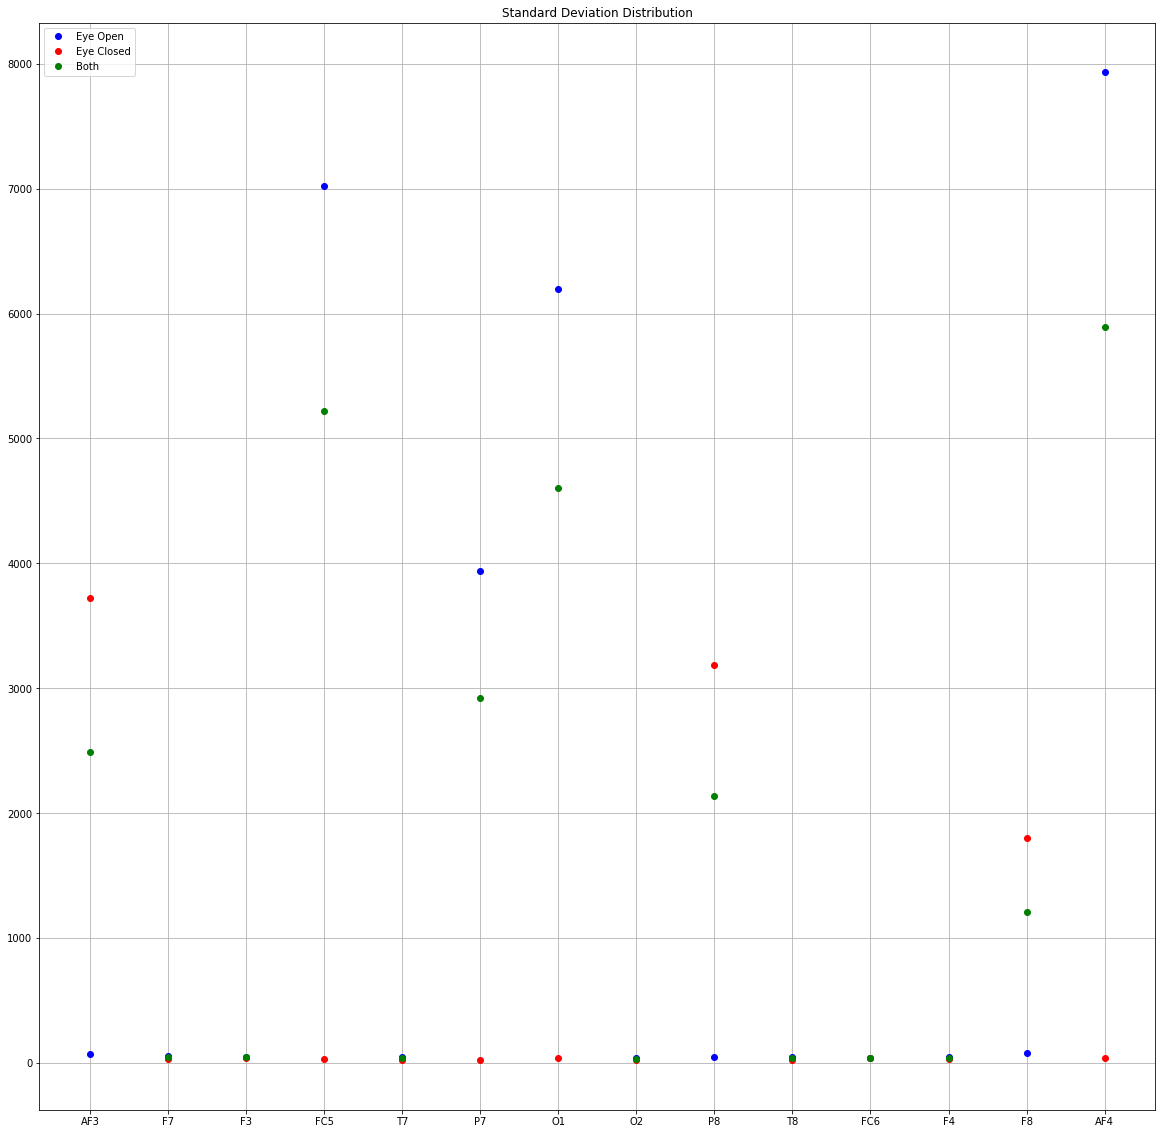

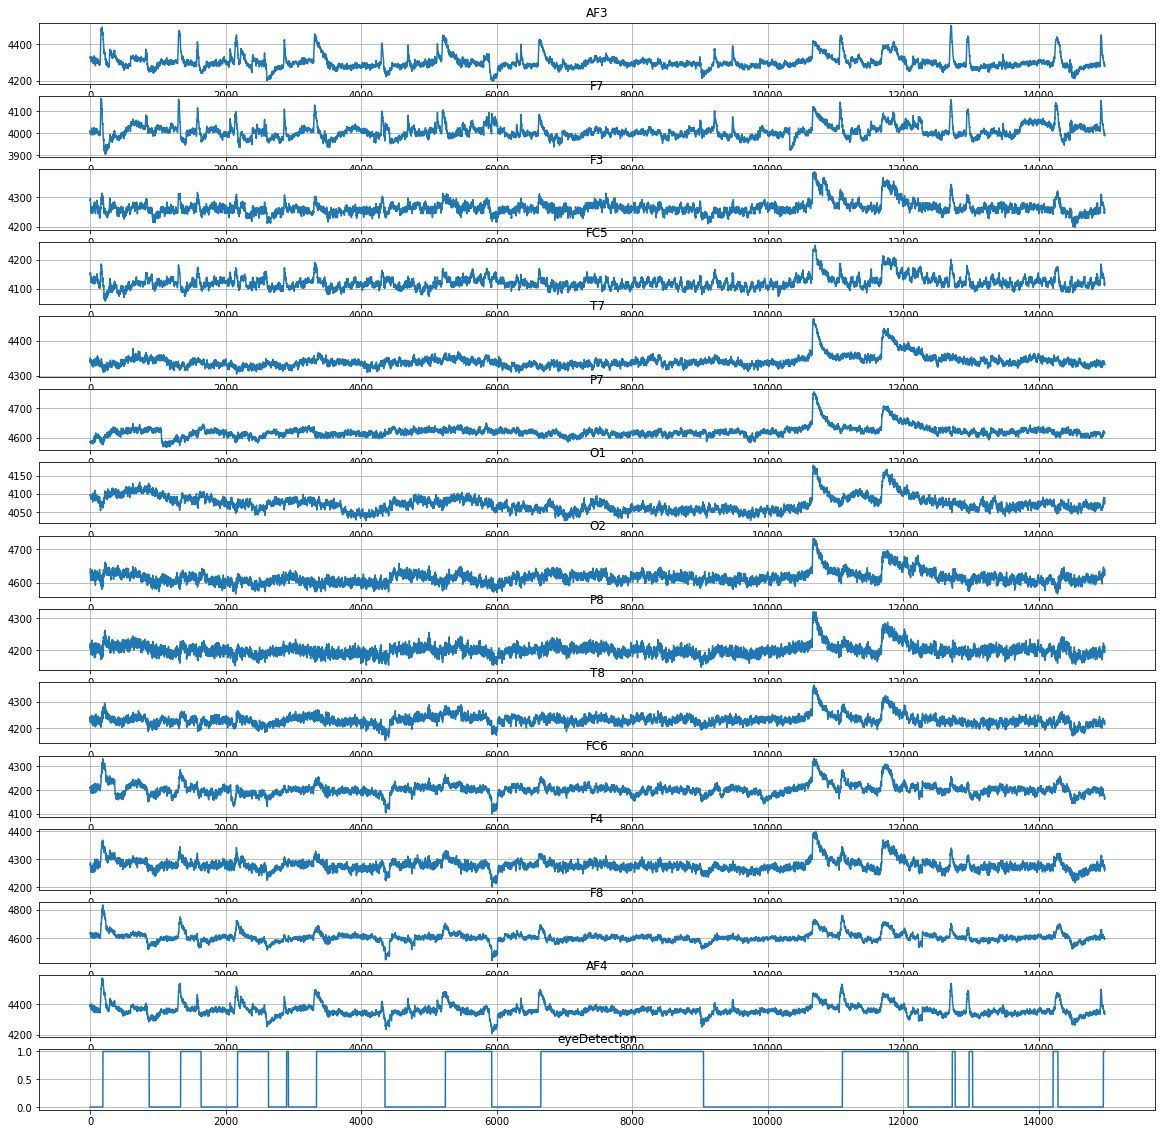

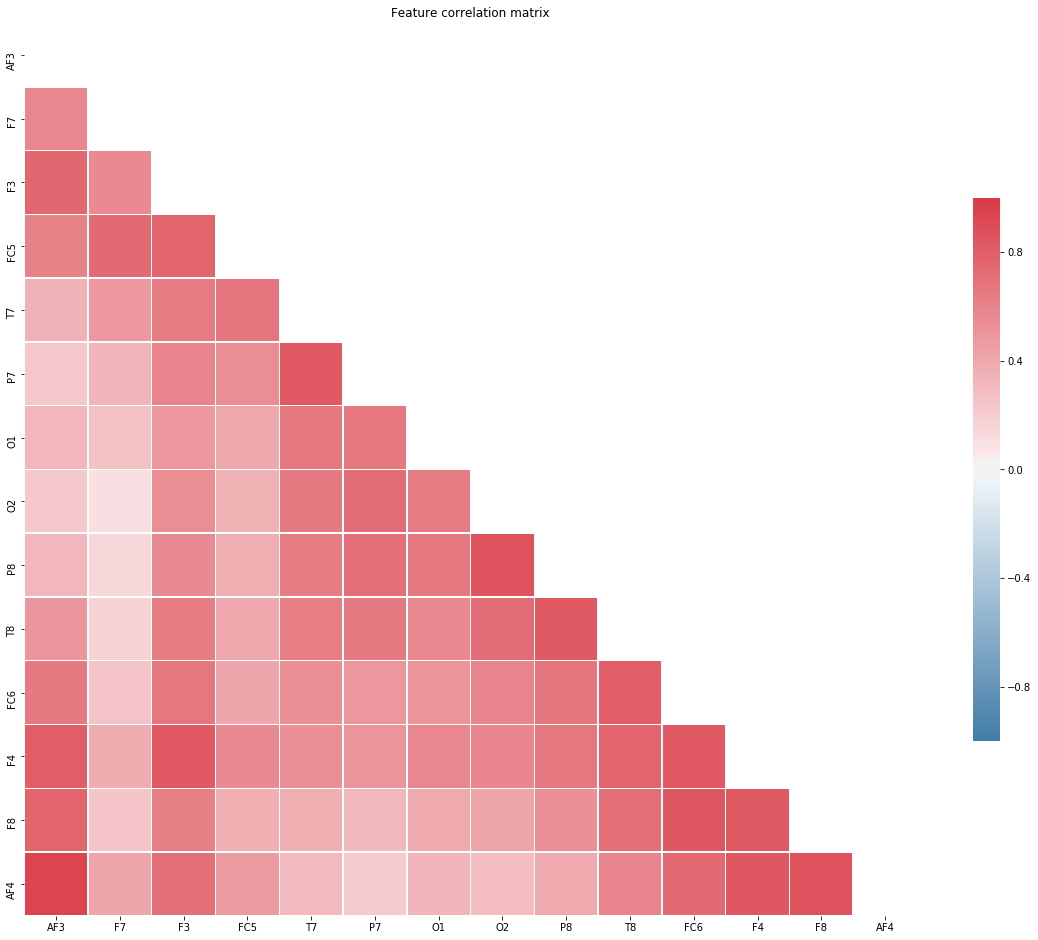

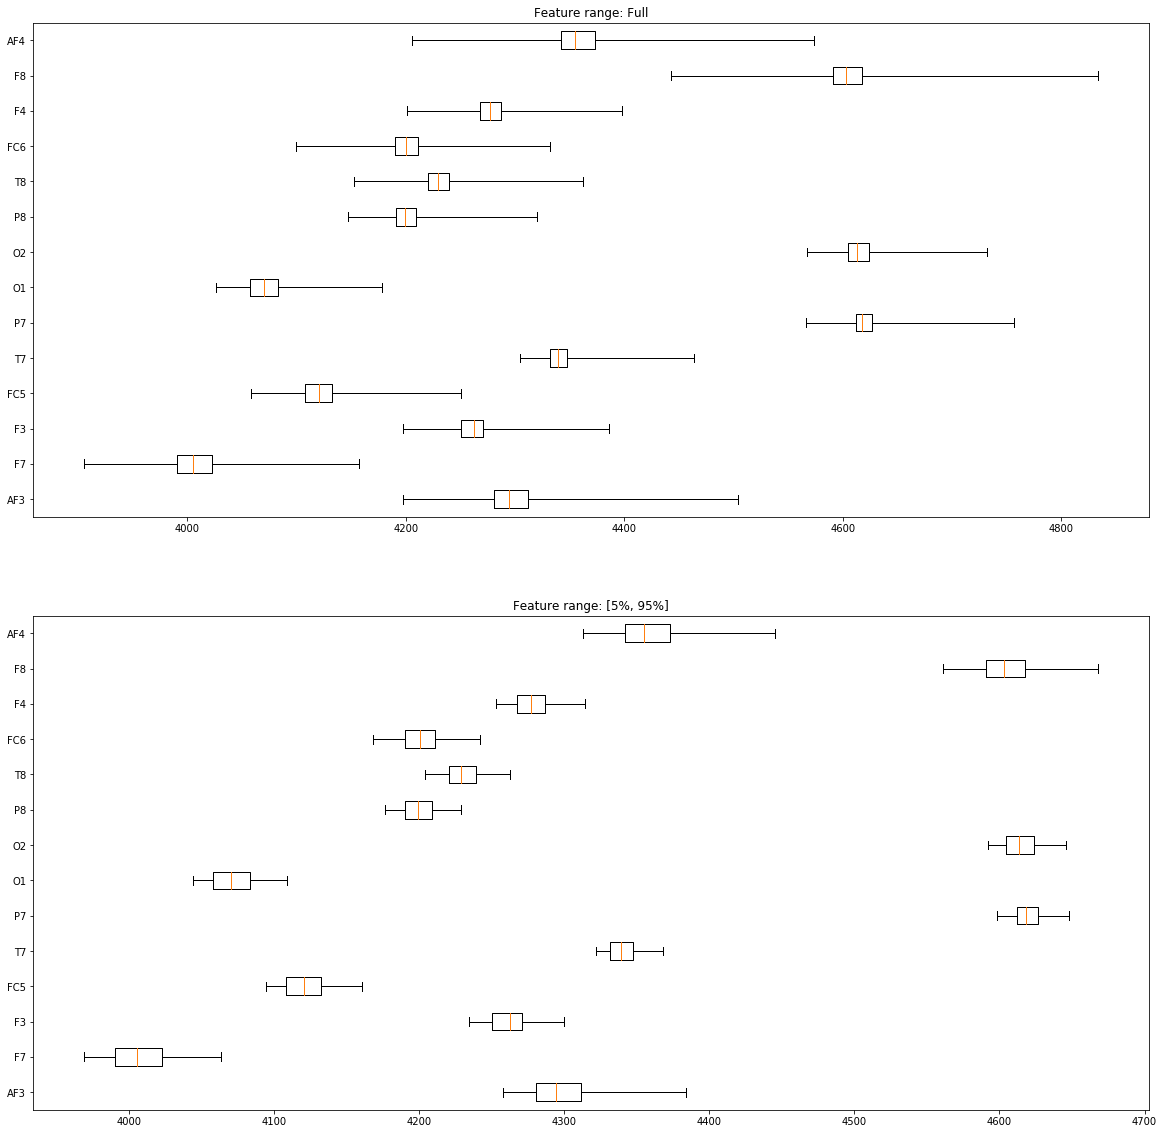

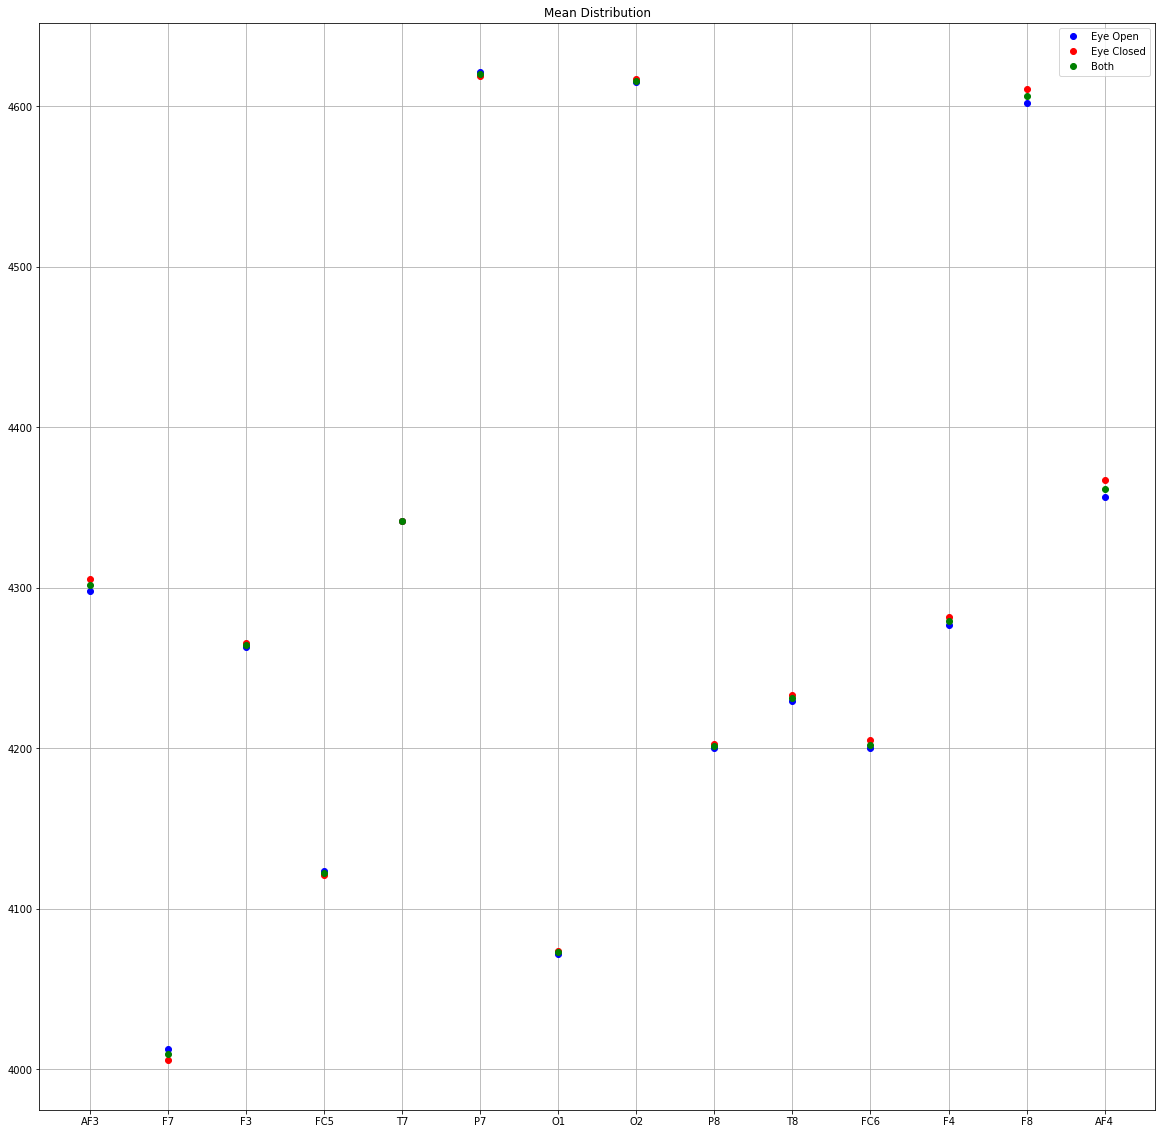

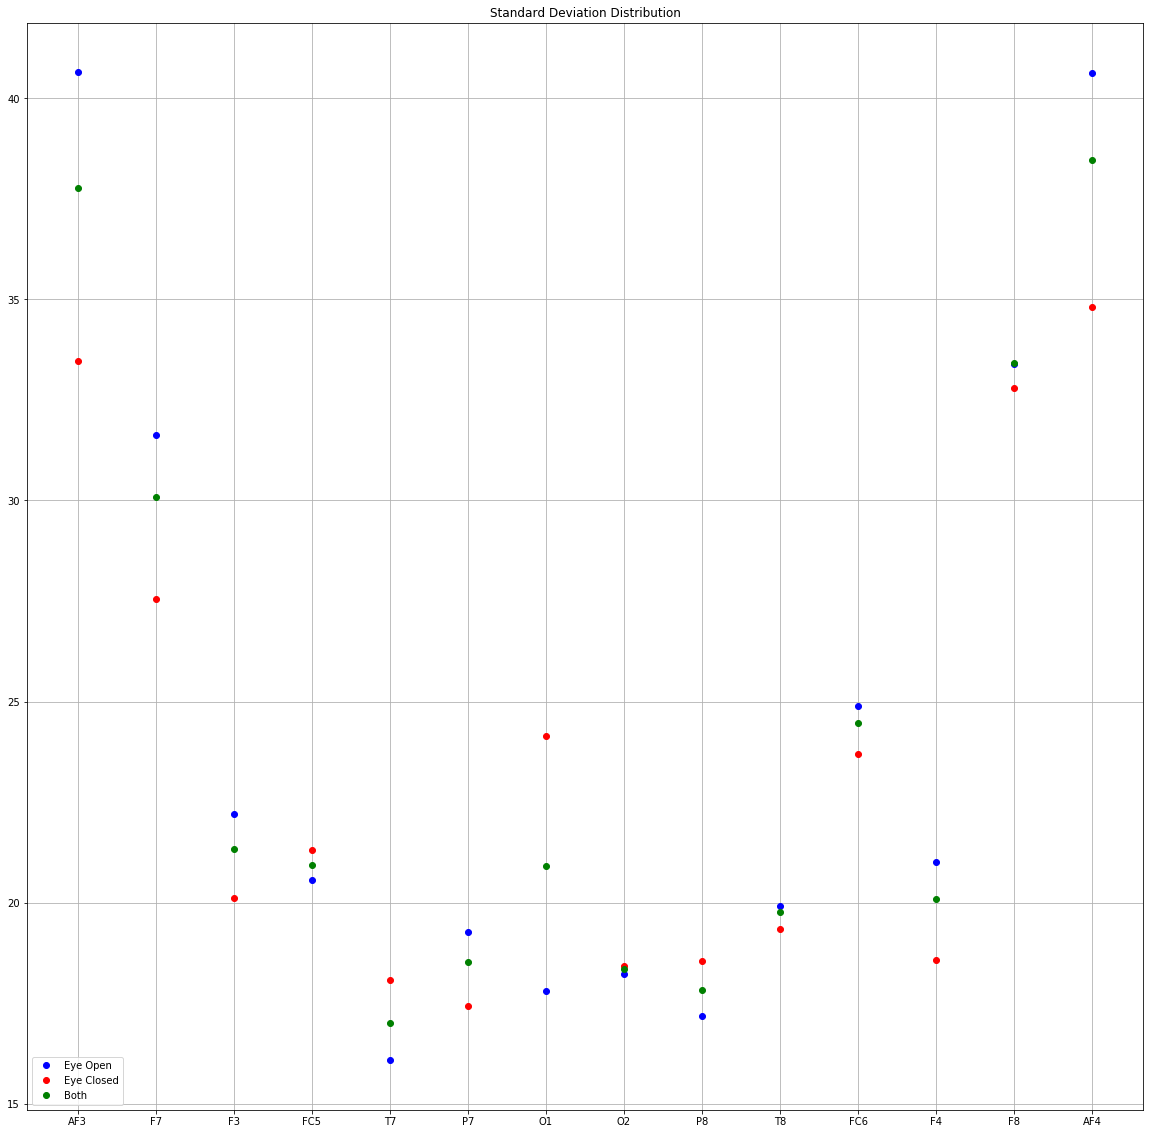

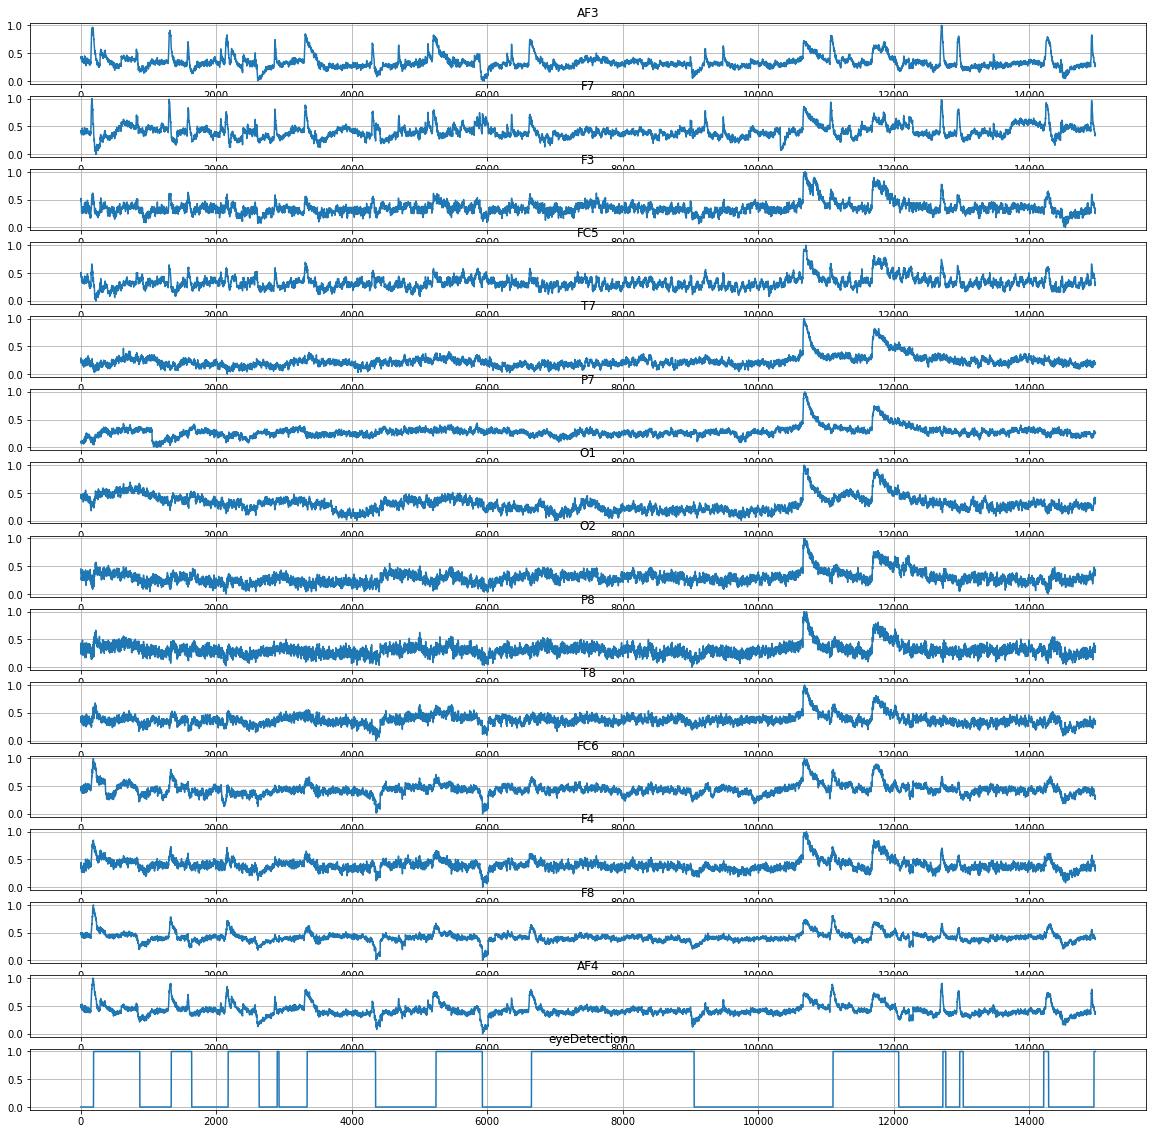

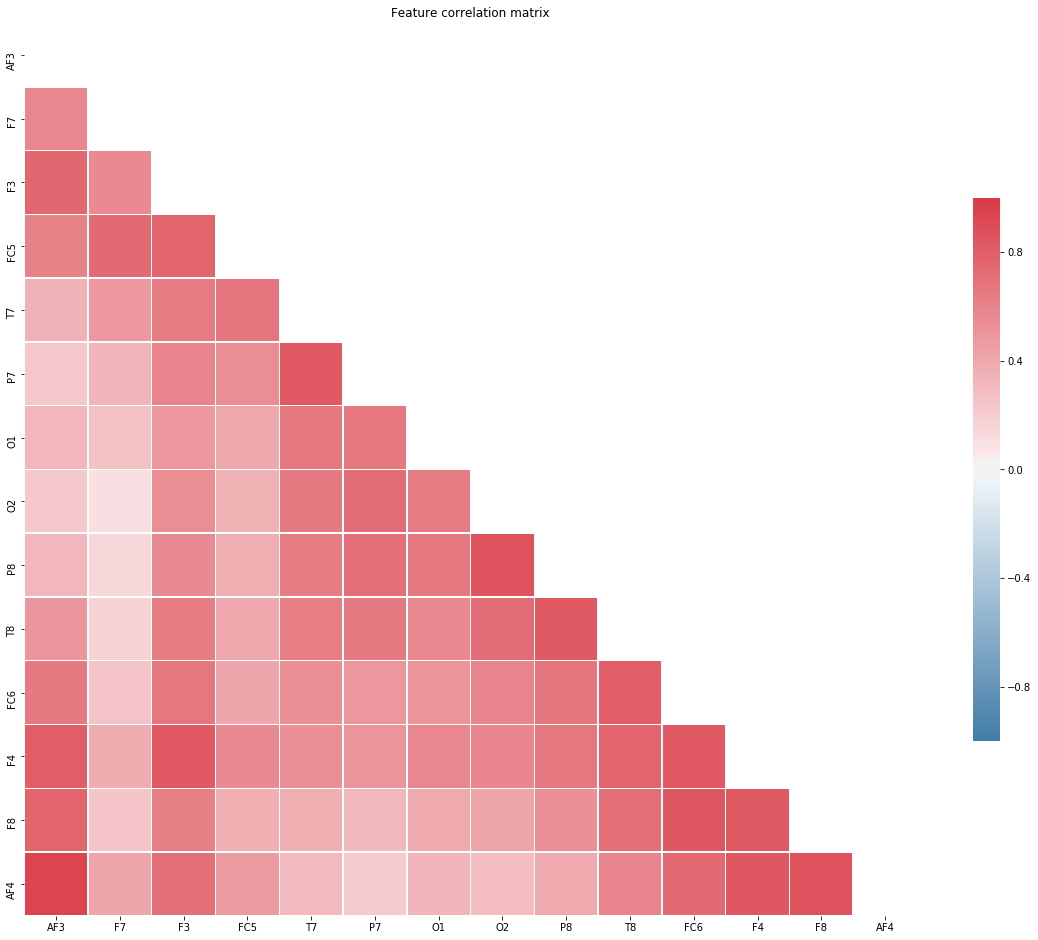

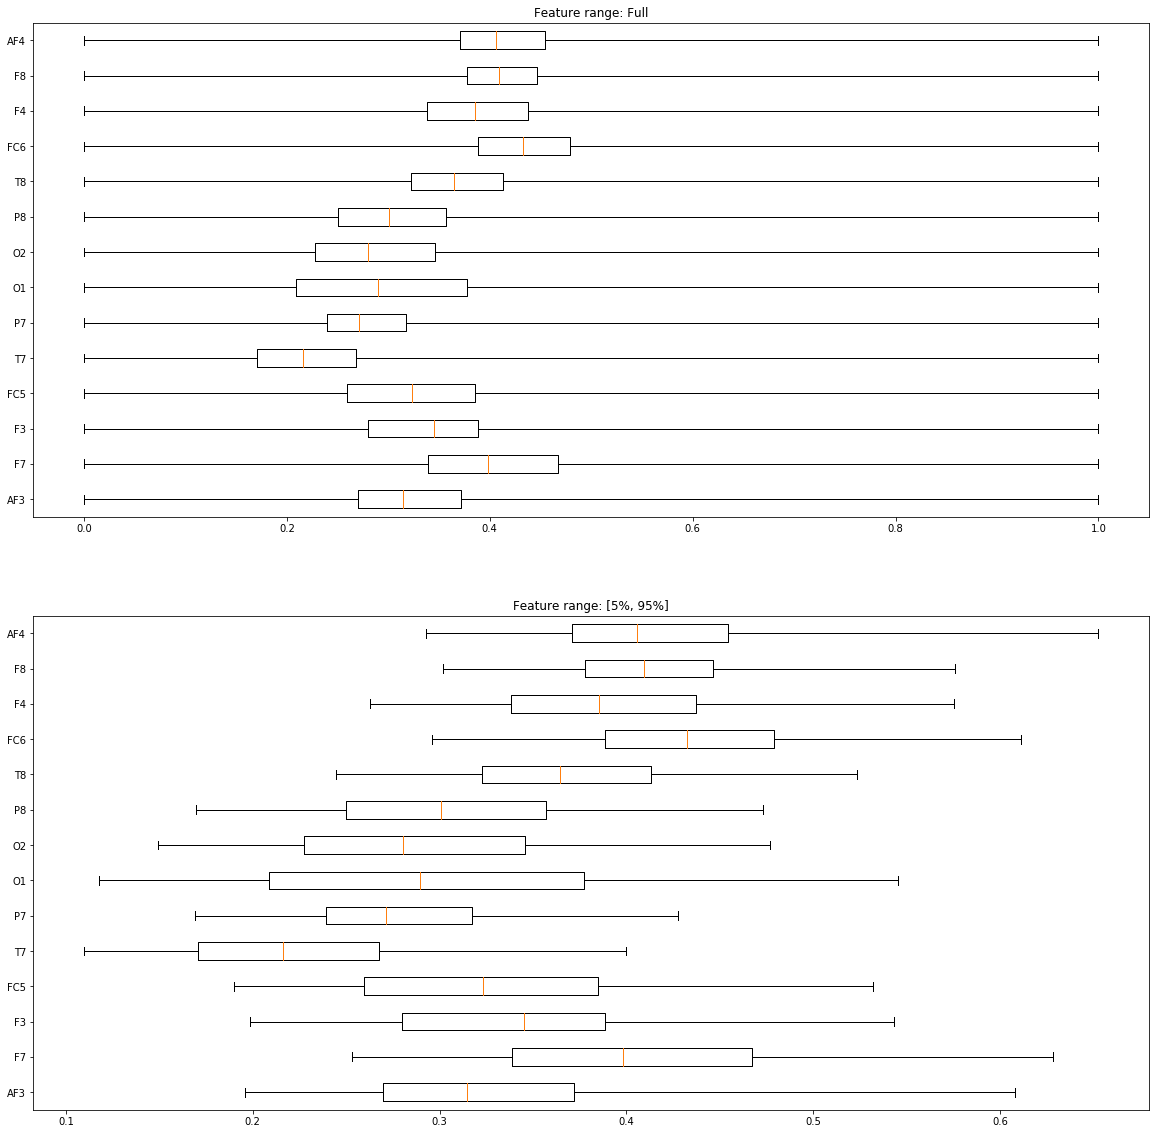

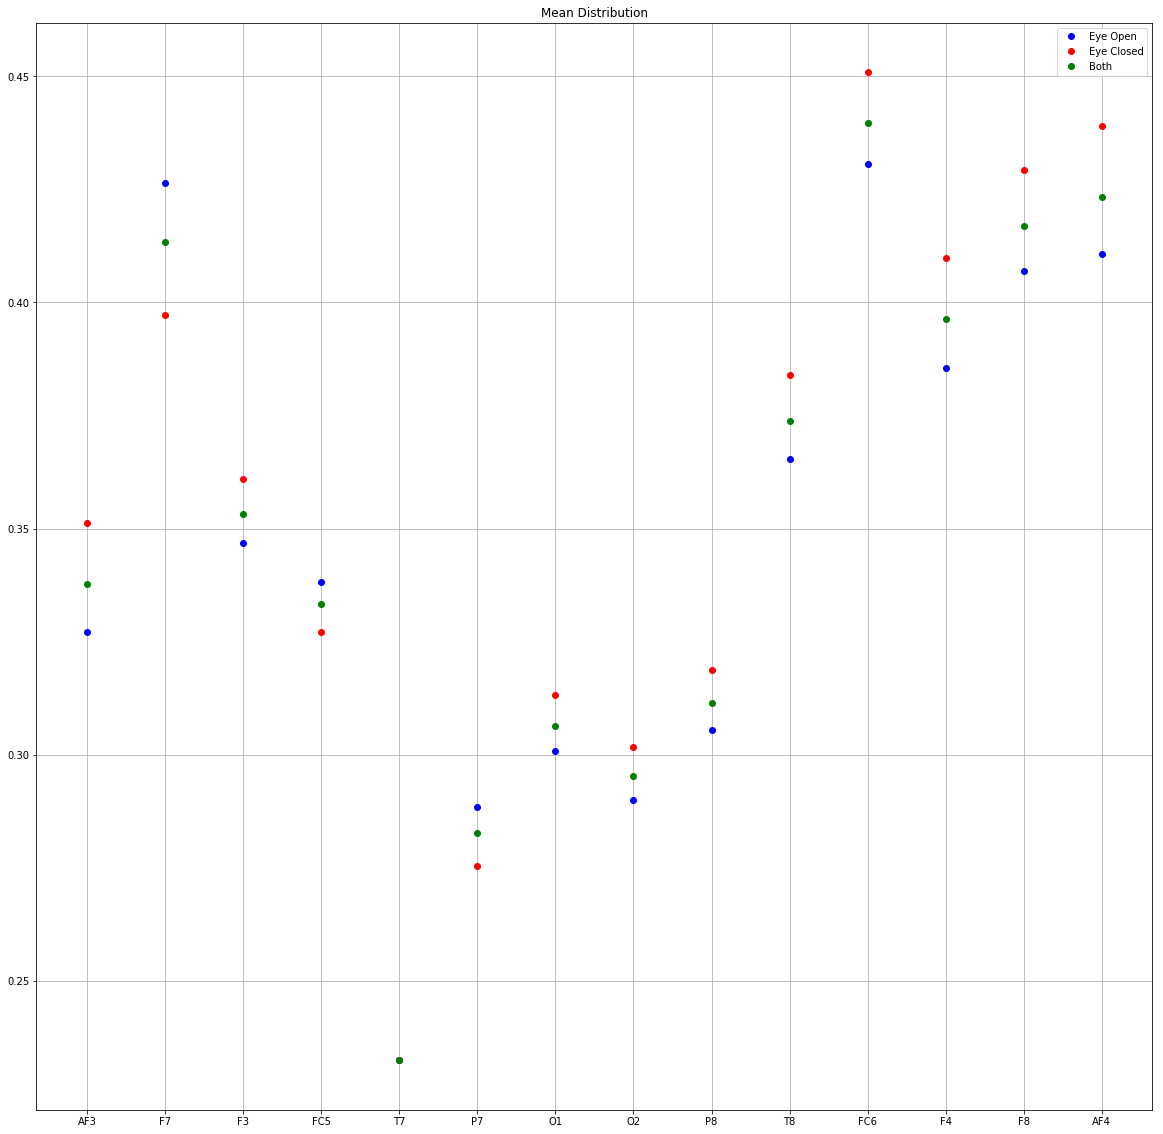

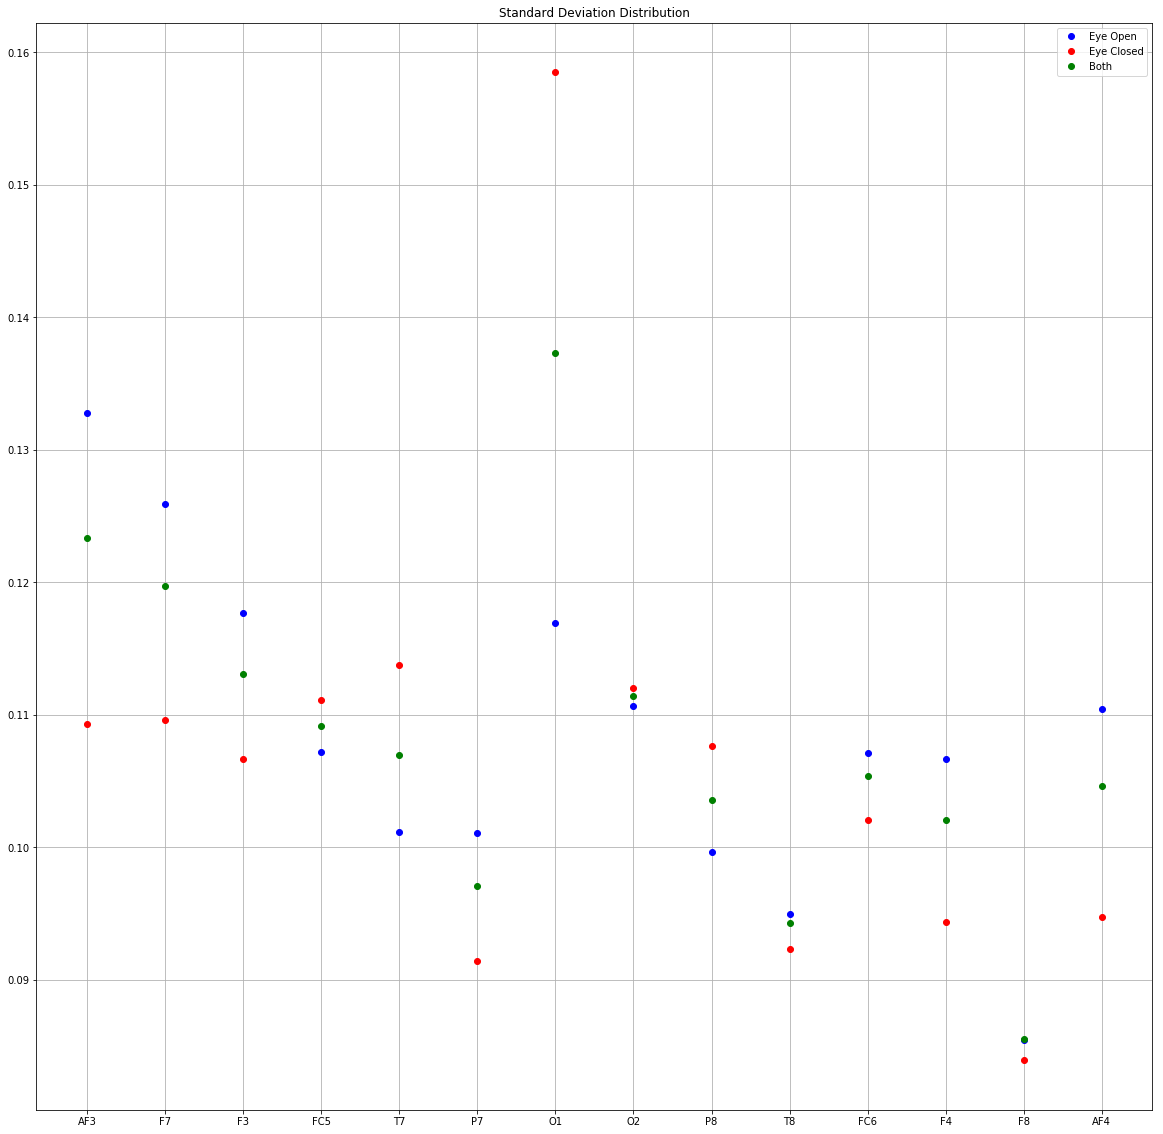

In [37]:
testID += 1

print "TestID: ", testID
a = Test(testID, 'EEGEyeState.arff.csv')


# a.CompileModel(1, 0.2, 50, 'aaaa')
# a.FitModel(10, 64)

# def CompileModel(self, lagCount, testSetPortion, neuronCount, modelArchitectureFilename,
#                  lossFunc='mae', optimizerFunc='adam'):

# print "--------------"
# result = a.GetFeatureNames()
# print result

# # a.RemoveFeature(0)
# # a.RemoveFeature(0)
# # a.RemoveFeature(0)
# # a.RemoveFeature(0)
# # a.RemoveFeature(0)
# # result = a.GetFeatureNames()
# # print result

a.PlotFeatures(filePrefix='01_RawData')
a.FeatureCorrelationMatrix(filePrefix='02_CorrelationMatrix_RawData')
a.PlotBoxPlots(filePrefix='03_BoxPlot_RawData')
a.PlotMeanDistribution('04_MeanDistribution_RawData')
a.PlotStdDevDistribution('05_StdDevDistribution_RawData')

res = a.RemoveOutliers(upperLimit=5000)
a.PlotFeatures(filePrefix='06_RemovedOutliers')
a.FeatureCorrelationMatrix(filePrefix='07_CorrelationMatrix_OutliersRemoved')
a.PlotBoxPlots(filePrefix='08_BoxPlot_OutliersRemove')
a.PlotMeanDistribution('09_MeanDistribution_OutliersRemove')
a.PlotStdDevDistribution('10_StdDevDistribution_OutliersRemove')

a.NormalizeData()
a.PlotFeatures(filePrefix='11_NormalizedData')
a.FeatureCorrelationMatrix(filePrefix='12_CorrelationMatrix_NormalizedData')
a.PlotBoxPlots(filePrefix='13_BoxPlot_NormalizedData')
a.PlotMeanDistribution('14_MeanDistribution_NormalizedData')
a.PlotStdDevDistribution('15_StdDevDistribution_NormalizedData')

print a.GetCmdHistory()

# (2994, 2, 22)
# (2994,)
# (11980, 2, 22)
# (11980,)

In [281]:
aaa = np.full(5, True, dtype=bool)
aaa[2] = aaa[4] = False
print aaa
res = np.where(aaa == True)
print res
print len(res[0])

[ True  True False  True False]
(array([0, 1, 3]),)
3


In [402]:
x = {}
x['aaa'] = set()
x['aaa'].add(1)
x['aaa'].add(2)
x['aaa'].add(3)

x['bbb'] = set()
# x['bbb'].add(1)
# x['bbb'].add(200)
# x['bbb'].add(3)


res = x['bbb'].union(x['aaa'])
print res


set([1, 2, 3])


In [9]:
cmd = str('')
cmd += 'aa'

print cmd

aa
